In [0]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

num_workers = 4
batch_size = 20


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        ## encoder layers ##
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8 , 3, stride=1, padding=1),
            nn.ReLU(),     
            nn.MaxPool2d(2),                   
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 8, 3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 32, 2, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1),
            nn.Sigmoid(),
        )


    def forward(self, x):
        x = self.encoder(x)
        # print(x.size())
        x = self.decoder(x)
        #print(x.size())
        return x

# initialize the NN
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ConvDenoiser().to(device)
print(model)


ConvDenoiser(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Sigmoid()
  )
)


In [0]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [0]:
n_epochs = 50
noise_factor=0.5
train_losses = []
val_losses = []

for epoch in range(1, n_epochs+1):
    model.train() 
    train_loss = 0.0
    val_loss = 0.0
    for data in train_loader:
        images, _ = data        
        ## add random noise to the input images
        noisy_imgs = images + noise_factor * torch.randn(*images.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
                
        
        optimizer.zero_grad()
        outputs = model(noisy_imgs.to(device))
        images = images.to(device)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
        torch.save(model.state_dict(), "mnist_autoencoder.pt")

    with torch.no_grad():
        for data in test_loader:
            images, _ = data        
            ## add random noise to the input images
            noisy_imgs = images + noise_factor * torch.randn(*images.shape)
            # Clip the images to be between 0 and 1
            noisy_imgs = np.clip(noisy_imgs, 0., 1.)                 
            outputs = model(noisy_imgs.to(device))
            images = images.to(device)
            loss_ = criterion(outputs, images)
            val_loss += loss_.item()*images.size(0)

    
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    val_loss = val_loss/len(test_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, 
        train_loss,
        val_loss
        ))

Epoch: 1 	Training Loss: 1.019177 	Validation Loss: 0.778265
Epoch: 2 	Training Loss: 0.690081 	Validation Loss: 0.657037
Epoch: 3 	Training Loss: 0.611810 	Validation Loss: 0.603772
Epoch: 4 	Training Loss: 0.582397 	Validation Loss: 0.589652
Epoch: 5 	Training Loss: 0.566222 	Validation Loss: 0.565855
Epoch: 6 	Training Loss: 0.553643 	Validation Loss: 0.561248
Epoch: 7 	Training Loss: 0.543259 	Validation Loss: 0.544659
Epoch: 8 	Training Loss: 0.533850 	Validation Loss: 0.546209
Epoch: 9 	Training Loss: 0.525904 	Validation Loss: 0.548626
Epoch: 10 	Training Loss: 0.518497 	Validation Loss: 0.536697
Epoch: 11 	Training Loss: 0.512798 	Validation Loss: 0.527401
Epoch: 12 	Training Loss: 0.507813 	Validation Loss: 0.518320
Epoch: 13 	Training Loss: 0.503967 	Validation Loss: 0.519755
Epoch: 14 	Training Loss: 0.499950 	Validation Loss: 0.527842
Epoch: 15 	Training Loss: 0.497154 	Validation Loss: 0.501709
Epoch: 16 	Training Loss: 0.495168 	Validation Loss: 0.503331
Epoch: 17 	Traini

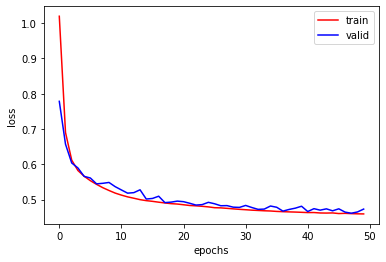

In [0]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(train_losses, 'r', label="train")
plt.plot(val_losses, 'b', label="valid")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

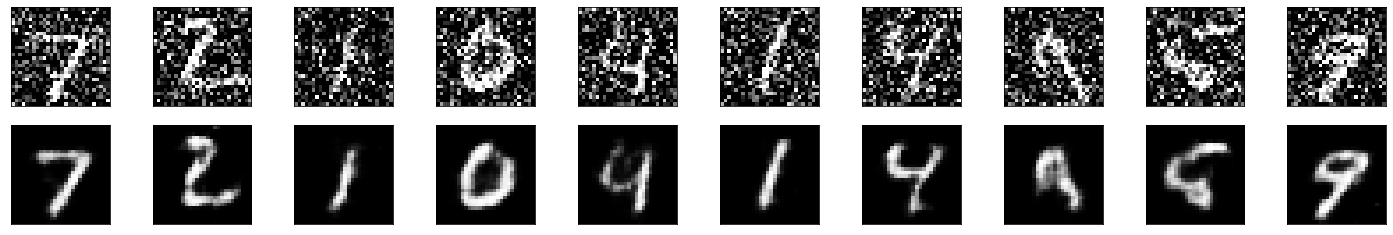

In [0]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# add noise to the test images
noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

# get sample outputs
noisy_imgs = noisy_imgs.to(device)
output = model(noisy_imgs)
# prep images for display
noisy_imgs = noisy_imgs.cpu().numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.cpu().detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for noisy_imgs, row in zip([noisy_imgs, output], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

net = nn.Sequential(
    *list(model.children())[:-1]
    )

for param in net.parameters():
    param.requires_grad = False
 
net.add_module(
    'flatten features', Flatten())
net.add_module(
    'classifier', nn.Sequential(nn.Linear(72,10),
    nn.LogSoftmax(dim=1))
    )
print(net)

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten features): Flatten()
  (classifier): Sequential(
    (0): Linear(in_features=72, out_features=10, bias=True)
    (1): LogSoftmax()
  )
)


In [0]:
epochs = 150
torch.optim.Adam(model.parameters(), lr=0.001)
net = net.to(device)
noise_factor=0.5


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        noisy_imgs = data + noise_factor * torch.randn(*data.shape).to(device)
        noisy_imgs.to(device)
        optimizer.zero_grad()
        output = model(noisy_imgs)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        torch.save(model.state_dict(), "mnist_cnn.pt")

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            noisy_imgs = data + noise_factor * torch.randn(*data.shape).to(device)
            output = model(noisy_imgs)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

for epoch in range(1, epochs + 1):
        train(net, device, train_loader, optimizer, epoch)
        test(net, device, test_loader)


Train Epoch: 1 [0/60000 (0%)]	Loss: 18.874172
Train Epoch: 1 [20000/60000 (33%)]	Loss: 20.236538
Train Epoch: 1 [40000/60000 (67%)]	Loss: 20.991684

Test set: Average loss: 19.5508, Accuracy: 1058/10000 (11%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 18.197302
Train Epoch: 2 [20000/60000 (33%)]	Loss: 20.769329
Train Epoch: 2 [40000/60000 (67%)]	Loss: 20.933369

Test set: Average loss: 19.5674, Accuracy: 1062/10000 (11%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 18.047237
Train Epoch: 3 [20000/60000 (33%)]	Loss: 19.902948
Train Epoch: 3 [40000/60000 (67%)]	Loss: 20.985188

Test set: Average loss: 19.6113, Accuracy: 1058/10000 (11%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 19.449692
Train Epoch: 4 [20000/60000 (33%)]	Loss: 21.230795
Train Epoch: 4 [40000/60000 (67%)]	Loss: 21.168745

Test set: Average loss: 19.5755, Accuracy: 1065/10000 (11%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 19.243509
Train Epoch: 5 [20000/60000 (33%)]	Loss: 20.079874
Train Epoch: 5 [40000/60000 (67%)]	Loss: 20.354107

Test set: A

Predicted:      2     8     8     8


<Figure size 432x288 with 0 Axes>

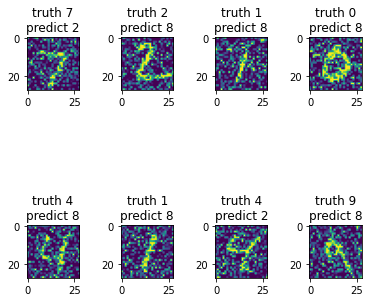

In [0]:
classes = ('0', '1', '2', '3',
          '4', '5', '6', '7', '8', '9')
         
import matplotlib.pyplot as plt
import numpy as np
import torchvision
#create an iterator for train_loader
# get random training images
data_iterator = iter(test_loader)
images, labels = data_iterator.next()
noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

# get sample outputs
noisy_imgs = noisy_imgs.to(device)
outputs = net(noisy_imgs)
_, predicted = torch.max(outputs, 1)
noisy_imgs = noisy_imgs.cpu()
#plot 4 images to visualize the data
rows = 2
columns = 4
fig=plt.figure()
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

fig2 = plt.figure()
for i in range(8):
   fig2.add_subplot(rows, columns, i+1)
   plt.title('truth ' + classes[labels[i]]+ '\n' + 'predict ' + classes[predicted[i]])
   #img = images[i] / 2 + 0.5     # this is to unnormalize the image
   img = noisy_imgs[i]/2 + 0.5
   img = torchvision.transforms.ToPILImage()(img)
   plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.0, wspace=0.8)
   plt.imshow(img)
plt.show()

In [0]:
predicted

In [0]:
labels